### IMPORT THE NECESSARY LIBRARIES

##### OS:
Used for traversing through different directories.
##### TENSORFLOW:
Used for implementing deep learning applications.
##### PANDAS:
Used for data analysis.
##### PYDICOM:
Used when working with Dicom files.

In [1]:
import os
import tensorflow as tf
import pandas as pd
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.regularizers import l2, l1
import cv2
import gradio as gr

C:\Users\HP\anaconda3\envs\tf-gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### RETRIEVING METADATA FOR THE DATASET IMAGES

Separating the records containing pulmonary embolism from those that do not contain pulmonary embolism.

In [2]:
dataset_dir = 'PE Classification Dataset'

In [3]:
data = pd.read_csv(os.path.join(dataset_dir, 'train.csv'))

In [4]:
# Retrieving PE records from train.csv file
data_pe = data.loc[data["pe_present_on_image"] == 1, :].reset_index(drop=True)
data_pe.loc[2597:2601]

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
2597,e38b906e0af0,a370c1f62c83,913ff9edc90b,1,0,0,0,0,0,1,1,0,0,1,0,0,0
2598,e38b906e0af0,a370c1f62c83,43c3764ef013,1,0,0,0,0,0,1,1,0,0,1,0,0,0
2599,e38b906e0af0,a370c1f62c83,e59797265a62,1,0,0,0,0,0,1,1,0,0,1,0,0,0
2600,e38b906e0af0,a370c1f62c83,f31486492429,1,0,0,0,0,0,1,1,0,0,1,0,0,0
2601,e38b906e0af0,a370c1f62c83,e357cda849e0,1,0,0,0,0,0,1,1,0,0,1,0,0,0


In [5]:
# Retrieving Non-PE records from train.csv file
data1 = pd.read_csv(os.path.join(dataset_dir, 'train.csv'))
data_no_pe = data1.loc[(data1["pe_present_on_image"] == 0) & (data1["negative_exam_for_pe"] == 1), :].reset_index(drop=True)
data_no_pe.loc[2596:2600]

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
2596,7b7d8152fb36,e19c6954d1fa,429046cf640b,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2597,7b7d8152fb36,e19c6954d1fa,f39baec0ea72,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2598,7b7d8152fb36,e19c6954d1fa,49ede8e8eb06,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2599,7b7d8152fb36,e19c6954d1fa,afdc68348b18,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2600,7b7d8152fb36,e19c6954d1fa,0b83e02ce62d,0,1,0,0,0,0,0,0,0,0,0,0,0,0


#### PREPROCESSING THE IMAGES

Converting the train, validation and test images from dicom format to jpg so as to work with them more easily.

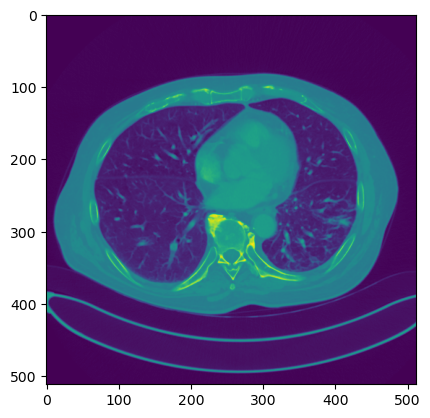

In [6]:
image = pydicom.dcmread(os.path.join(dataset_dir, 'data', 'converted_images', 'train_converted', 'pe_converted', '0e79a433e660.dcm'))
im = image.pixel_array.astype('float32')
scale = (np.maximum(im, 0)/im.max())
plt.imshow(scale)

In [7]:
def get_image_names(path):
    names = []
    for root, dirname, filenames in os.walk(path):
        for filename in filenames:
            _, ext = os.path.splitext(filename)
            if ext in ['.dcm']:
                names.append(filename)
    return names

In [8]:
train_pe_names = get_image_names(os.path.join(dataset_dir, 'data', 'train', 'pe'))

train_no_pe_names = get_image_names(os.path.join(dataset_dir, 'data', 'train', 'no_pe'))

valid_pe_names = get_image_names(os.path.join(dataset_dir, 'data', 'valid', 'pe'))

valid_no_pe_names = get_image_names(os.path.join(dataset_dir, 'data', 'valid', 'no_pe'))

test_pe_names = get_image_names(os.path.join(dataset_dir, 'data', 'test', 'pe'))

test_no_pe_names = get_image_names(os.path.join(dataset_dir, 'data', 'test', 'no_pe'))

In [9]:
def convert_pe_train_images_jpg(name):
    path = os.path.join(dataset_dir, 'data', 'train', 'pe',) + '\\' + name
    im = pydicom.dcmread(path)
    im = im.pixel_array.astype(float)
    rescale_image = (np.maximum(im, 0)/im.max()) * 255
    final_image= np.uint8(rescale_image)
    final_image = Image.fromarray(final_image).convert('RGB')
    return final_image

In [10]:
for name in train_pe_names:
    image = convert_pe_train_images_jpg(name)
    image.save(os.path.join(dataset_dir,'train_final', 'pe')+ '\\' + name + '.jpg')

In [11]:
def convert_no_pe_train_images_jpg(name):
    path = os.path.join(dataset_dir, 'data', 'train', 'no_pe',) + '\\' + name
    im = pydicom.dcmread(path)
    im = im.pixel_array.astype(float)
    rescale_image = (np.maximum(im, 0)/im.max()) * 255
    final_image= np.uint8(rescale_image)
    final_image = Image.fromarray(final_image).convert('RGB')
    return final_image

In [12]:
for name in train_no_pe_names:
    image = convert_no_pe_train_images_jpg(name)
    image.save(os.path.join(dataset_dir, 'train_final', 'no_pe')+ '\\' + name + '.jpg')

In [13]:
def convert_pe_valid_images_jpg(name):
    path = os.path.join(dataset_dir, 'data', 'valid', 'pe',) + '\\' + name
    im = pydicom.dcmread(path)
    im = im.pixel_array.astype(float)
    rescale_image = (np.maximum(im, 0)/im.max()) * 255
    final_image= np.uint8(rescale_image)
    final_image = Image.fromarray(final_image).convert('RGB')
    return final_image

In [14]:
for name in valid_pe_names:
    image = convert_pe_valid_images_jpg(name)
    image.save(os.path.join(dataset_dir, 'valid_final', 'pe')+ '\\' + name + '.jpg')

In [15]:
def convert_no_pe_valid_images_jpg(name):
    path = os.path.join(dataset_dir, 'data', 'valid', 'no_pe',) + '\\' + name
    im = pydicom.dcmread(path)
    im = im.pixel_array.astype(float)
    rescale_image = (np.maximum(im, 0)/im.max()) * 255
    final_image= np.uint8(rescale_image)
    final_image = Image.fromarray(final_image).convert('RGB')
    return final_image

In [16]:
for name in valid_no_pe_names:
    image = convert_no_pe_valid_images_jpg(name)
    image.save(os.path.join(dataset_dir, 'valid_final', 'no_pe')+ '\\' + name + '.jpg')

In [17]:
def convert_pe_test_images_jpg(name):
    path = os.path.join(dataset_dir, 'data', 'test', 'pe',) + '\\' + name
    im = pydicom.dcmread(path)
    im = im.pixel_array.astype(float)
    rescale_image = (np.maximum(im, 0)/im.max()) * 255
    final_image= np.uint8(rescale_image)
    final_image = Image.fromarray(final_image).convert('RGB')
    return final_image

In [18]:
for name in test_pe_names:
    image = convert_pe_test_images_jpg(name)
    image.save(os.path.join(dataset_dir, 'test_final', 'pe')+ '\\' + name + '.jpg')

In [19]:
def convert_no_pe_test_images_jpg(name):
    path = os.path.join(dataset_dir, 'data', 'test', 'no_pe',) + '\\' + name
    im = pydicom.dcmread(path)
    im = im.pixel_array.astype(float)
    rescale_image = (np.maximum(im, 0)/im.max()) * 255
    final_image= np.uint8(rescale_image)
    final_image = Image.fromarray(final_image).convert('RGB')
    return final_image

In [20]:
for name in test_no_pe_names:
    image = convert_no_pe_test_images_jpg(name)
    image.save(os.path.join(dataset_dir, 'test_final', 'no_pe')+ '\\' + name + '.jpg')

#### LOADING THE DATASET

In [21]:
# Load Data
dataset_train = tf.keras.utils.image_dataset_from_directory(os.path.join(dataset_dir, 'train_final'))

Found 3500 files belonging to 2 classes.


In [22]:
dataset_valid = tf.keras.utils.image_dataset_from_directory(os.path.join(dataset_dir, 'valid_final'))

Found 1000 files belonging to 2 classes.


In [23]:
dataset_test = tf.keras.utils.image_dataset_from_directory(os.path.join(dataset_dir, 'test_final'))

Found 500 files belonging to 2 classes.


In [24]:
class_names = dataset_train.class_names
print(class_names)

['no_pe', 'pe']


#### DETERMINING CLASS REPRESENTATION

After generating and loading the dataset, images containing pulmonary embolism are represented by 1 while those that do not contain pulmonary embolism are represented by 0.

In [25]:
iterator = dataset_train.as_numpy_iterator()
batch = iterator.next()
batch

# 1 - pe
# 0 - no pe

(array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

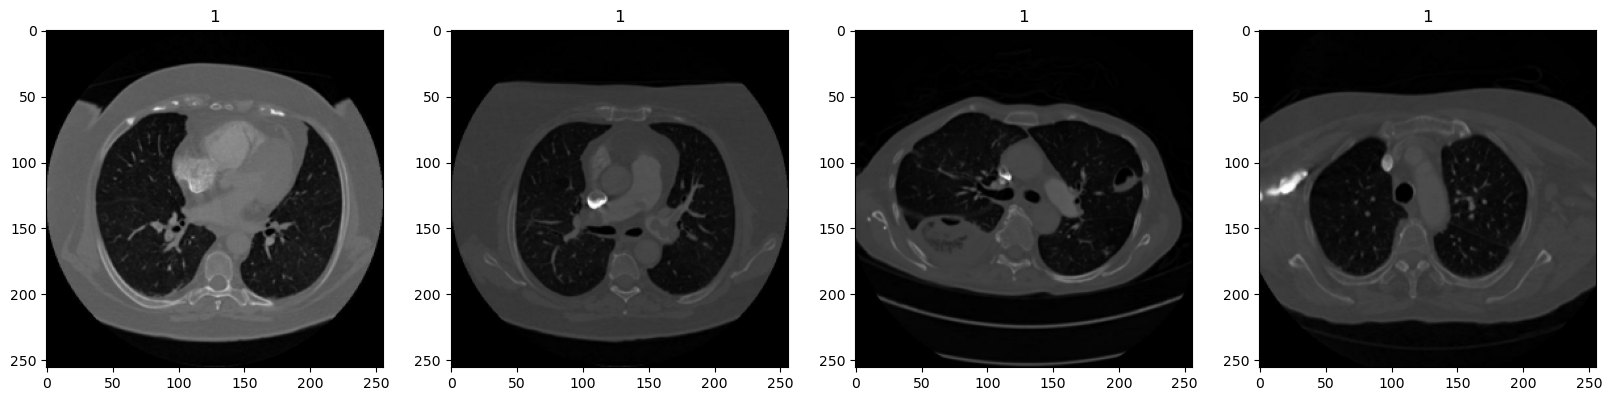

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

#### RESCALING THE IMAGES

In [27]:
dataset_train = dataset_train.map(lambda x,y: (x/255, y))
dataset_valid = dataset_valid.map(lambda x,y: (x/255, y))
dataset_test = dataset_test.map(lambda x,y: (x/255, y))

#### BUILDING THE MODEL

In [28]:
# Model
model = Sequential()

In [29]:
# Layers
model.add(Conv2D(32 , (3,3), padding = 'same' , activation = 'relu' , input_shape = ( 256, 256, 3), kernel_regularizer=l2(l=0.001)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64 , (3,3), padding = 'same' , activation = 'relu', kernel_regularizer=l2(l=0.0005)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128 , (3,3) , padding = 'same' , activation = 'relu', kernel_regularizer=l2(l=0.001)))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(units = 256 , activation = 'relu', kernel_regularizer=l2(l=0.0005)))
model.add(Dense(units = 1 , activation = 'sigmoid'))

In [30]:
model.compile(optimizer = SGD(learning_rate=0.0003, momentum=0.9), loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0

#### TRAINING THE MODEL

In [32]:
hist = model.fit(dataset_train, 
                           validation_data = dataset_valid,
                           batch_size=32,
                           epochs = 30,
                           verbose = 1)

Epoch 1/30
110/110 [==============================] - 28s 167ms/step - loss: 1.0379 - accuracy: 0.6946 - val_loss: 1.0104 - val_accuracy: 0.8580
Epoch 2/30
110/110 [==============================] - 17s 151ms/step - loss: 0.9478 - accuracy: 0.7614 - val_loss: 0.8955 - val_accuracy: 0.8440
Epoch 3/30
110/110 [==============================] - 17s 155ms/step - loss: 0.8302 - accuracy: 0.7991 - val_loss: 0.8314 - val_accuracy: 0.8710
Epoch 4/30
110/110 [==============================] - 17s 156ms/step - loss: 0.7394 - accuracy: 0.8437 - val_loss: 0.8032 - val_accuracy: 0.8230
Epoch 5/30
110/110 [==============================] - 17s 153ms/step - loss: 0.6614 - accuracy: 0.8823 - val_loss: 0.8800 - val_accuracy: 0.7500
Epoch 6/30
110/110 [==============================] - 17s 153ms/step - loss: 0.6096 - accuracy: 0.9034 - val_loss: 0.8059 - val_accuracy: 0.8040
Epoch 7/30
110/110 [==============================] - 17s 154ms/step - loss: 0.5570 - accuracy: 0.9323 - val_loss: 0.8208 - val_ac

In [33]:
hist.history

{'loss': [1.037861943244934,
  0.9477947950363159,
  0.830227792263031,
  0.7393634915351868,
  0.6614184975624084,
  0.6096007823944092,
  0.5570152997970581,
  0.5101698637008667,
  0.4878097474575043,
  0.4561346173286438,
  0.43127045035362244,
  0.4168580174446106,
  0.4064624011516571,
  0.40381529927253723,
  0.3913794755935669,
  0.38370487093925476,
  0.3829419016838074,
  0.37800461053848267,
  0.37822672724723816,
  0.37459978461265564,
  0.37119001150131226,
  0.3699359893798828,
  0.3692631721496582,
  0.368488609790802,
  0.36854544281959534,
  0.3672082722187042,
  0.3662964105606079,
  0.3658086657524109,
  0.3653063178062439,
  0.3647257387638092],
 'accuracy': [0.6945714354515076,
  0.7614285945892334,
  0.7991428375244141,
  0.8437142968177795,
  0.8822857141494751,
  0.9034285545349121,
  0.932285726070404,
  0.9568571448326111,
  0.9651428461074829,
  0.9762856960296631,
  0.9851428866386414,
  0.9897142648696899,
  0.9925714135169983,
  0.9908571243286133,
  0.996

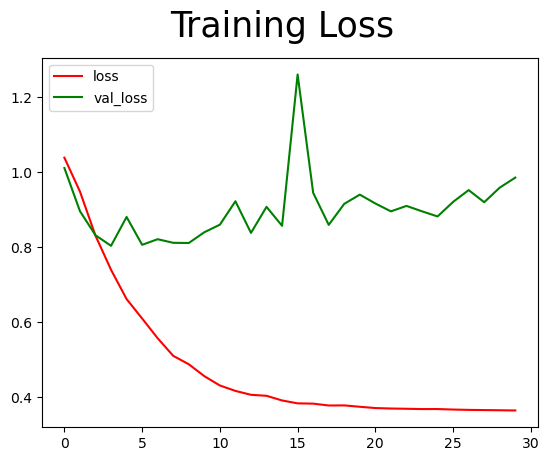

In [34]:
graph_loss = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['val_loss'], color='green', label='val_loss')
graph_loss.suptitle('Training Loss', fontsize=25)
plt.legend(loc="upper left")
plt.show()

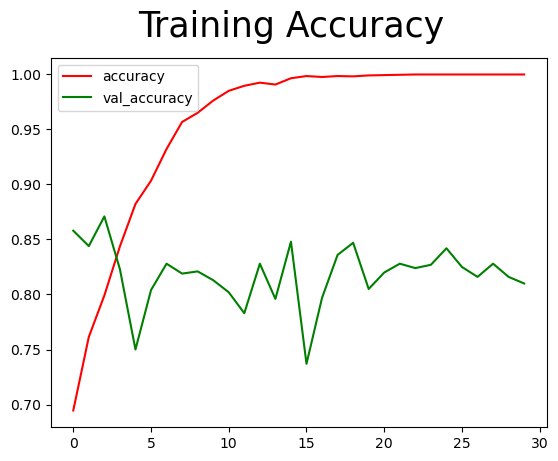

In [35]:
graph_acc = plt.figure()
plt.plot(hist.history['accuracy'], color='red', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='green', label='val_accuracy')
graph_acc.suptitle('Training Accuracy', fontsize=25)
plt.legend(loc="upper left")
plt.show()

#### TESTING THE MODEL

In [36]:
pc = Precision()
rc = Recall()
acc = BinaryAccuracy()

In [37]:
for batch in dataset_test.as_numpy_iterator():
    x,y = batch
    yhat = model.predict(x)
    pc.update_state(y,yhat)
    rc.update_state(y,yhat)
    acc.update_state(y,yhat)

In [38]:
print(f'Precision:{pc.result().numpy()}, Recall:{rc.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.7490494251251221, Recall:0.7879999876022339, Accuracy:0.762890636920929


##### TESTING WITH RANDOM IMAGES

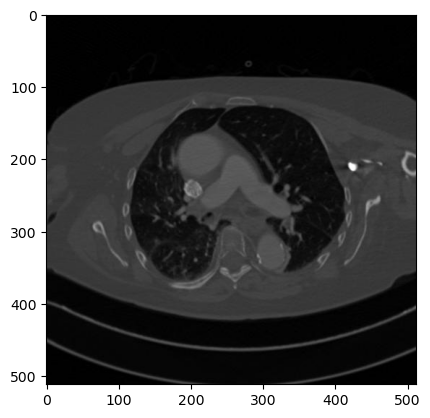

In [39]:
img = cv2.imread(os.path.join(dataset_dir, 'rand_test', 'no_pe', '3b2ff6ab1ed0.dcm.jpg'))
plt.imshow(img)
plt.show()

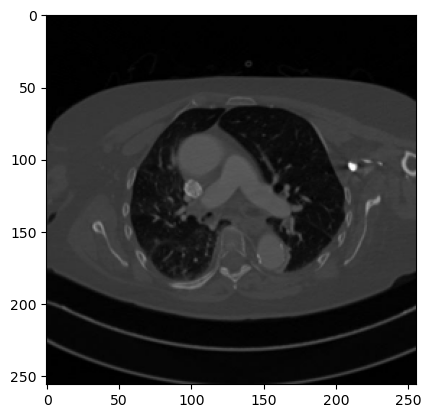

In [40]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [41]:
resize.shape

TensorShape([256, 256, 3])

In [42]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [43]:
pred_test = model.predict(np.expand_dims(resize/255,0))

In [44]:
pred_test

array([[0.999798]], dtype=float32)

In [45]:
if pred_test > 0.5:
    print(f'Image does not contain pulmonary embolism')
else:
    print(f'Image contains pulmonary embolism')    

Image does not contain pulmonary embolism


##### USING GRADIO FOR THE INTERFACE

In [46]:
def predict_image(img):
    img = img.reshape(1,256,256,3)
    prediction = model.predict(img)[0]
    return {class_names[i]: prediction[i] for i in range(2)}

In [47]:
im = gr.inputs.Image(shape=(256,256))

C:\Users\HP\anaconda3\envs\tf-gpu\lib\site-packages\gradio\inputs.py:256: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\HP\anaconda3\envs\tf-gpu\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [48]:
p_interface = gr.Interface(fn = predict_image,
                          inputs = im,
                          outputs = gr.outputs.Label(num_top_classes=2),
                          interpretation='default')

C:\Users\HP\anaconda3\envs\tf-gpu\lib\site-packages\gradio\outputs.py:196: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
C:\Users\HP\anaconda3\envs\tf-gpu\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [ ]:
p_interface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
